In [1]:
# Import Packages and setup
import logging
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)
logger = logging.getLogger("proxmin")
logger.setLevel(logging.DEBUG)


import autograd.numpy as np
import scarlet
import scarlet.display
from scarlet.display import AsinhMapping

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

loading data from'/Users/fred3m/data/hsc_deep/blend_10.npz'


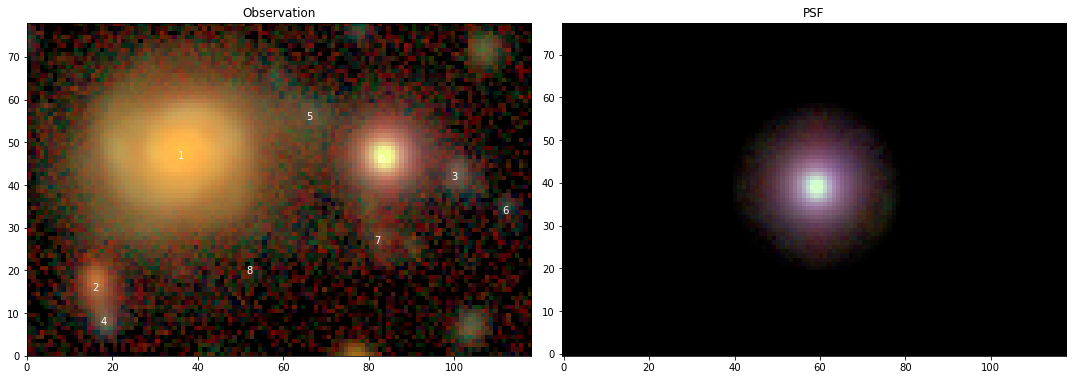

In [6]:
import os

filters = "grizy"

#idx = 3
#idx = 5
#idx = 8
idx = 10
#idx = 11
#idx = 12
#idx=22

#idx = 1
#idx = 4
#idx = 15
#idx = 35



#idx=60
#idx=100
#idx=112
#idx=47
#idx=14
#idx=106
#idx=54
#idx = 89
#idx = 91

datapath = "/Users/fred3m/data/hsc_deep"
filename = "blend_{0}.npz".format(idx)
print("loading data from'{0}'".format(os.path.join(datapath, filename)))

#datapath = "/Users/fred/temp/data"
#filename = "fail_max.npz"

data = np.load(os.path.join(datapath, filename))

filter_indices = [2, 1, 0]
stretch = .5
Q = 10

images = data["image"]
mask = data["mask"]
variance = data["variance"]
weights = 1/variance
#weights = np.ones(len(filters))[:,None,None] * 10 # inverse variance weights
#weights = data["weights"]
psf = scarlet.ImagePSF(data["psf"])
centers = data["peaks"]

model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(filters))

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images,
    psf=psf,
    weights=weights,
    channels=filters).match(model_frame)

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True, figsize=(15,9))
plt.show()

In [162]:
def get_valid(i, j, image, invalid, variance, orphans):
    if i > 0 and invalid[i-1, j]:
        if image[i-1,j] < image[i,j]+variance:
            invalid[i-1, j] = False
            get_valid(i-1, j, image, invalid, variance, orphans)
        else:
            orphans[i-1,j] = True
    if i < image.shape[0]-1 and invalid[i+1, j]:
        if image[i+1, j] < image[i, j]+variance:
            invalid[i+1, j] = False
            get_valid(i+1, j, image, invalid, variance, orphans)
        else:
            orphans[i+1,j] = True
    if j > 0 and invalid[i, j-1]:
        if image[i, j-1] < image[i,j]+variance:
            invalid[i, j-1] = False
            get_valid(i, j-1, image, invalid, variance, orphans)
        else:
            orphans[i,j-1] = True
    if j < image.shape[1]-1 and invalid[i, j+1]:
        if image[i, j+1] < image[i, j]+variance:
            invalid[i, j+1] = False
            get_valid(i, j+1, image, invalid, variance, orphans)
        else:
            orphans[i,j+1] = True

def fill_invalid(orphans, invalid, image, model, variance):
    all_i, all_j = np.where(orphans)
    newOrphans = np.zeros(image.shape, dtype=bool)
    for i,j in zip(all_i, all_j):
        # Even if we can't set this bit, there is no need to
        # consider it as a possible orphan in the next round
        invalid[i,j] = False
        update = 0
        if i < image.shape[0]-2:
            grad = np.abs(image[i+2, j] - image[i+1, j])
            update = image[i+1, j] - grad
        if i > 1:
            grad = np.abs(image[i-2,j] - image[i-1, j])
            update = np.max([update, image[i-1, j] - grad])
        if j < image.shape[1]-2:
            grad = np.abs(image[i, j+2] - image[i, j+1])
            update = np.max([update, image[i, j+1] - grad])
        if j > 1:
            grad = np.abs(image[i, j-2] - image[i, j-1])
            update = np.max([update, image[i, j-1] - grad])
        if update > 0:
            model[i,j] = update
            get_valid(i, j, image, invalid, variance, newOrphans)
    mask = model <= 0
    model[mask] = image[mask] * ~invalid[mask]
    return newOrphans

def get_center(image, center, radius=1):
    # We need to check around the given center to make sure
    # that we aren't off by a pixel
    cy, cx = int(center[0]), int(center[1])
    ySlice = slice(cy - radius, cy + radius+1)
    xSlice = slice(cx - radius, cx + radius+1)
    subset = image[ySlice, xSlice]
    center = np.unravel_index(np.argmax(subset), subset.shape)
    return (center[0]+cy-radius, center[1]+cx-radius)

def monotonic_tree(morph, center, radius=1, variance=0, show=False, max_iter=3):
    i, j = get_center(morph, center, radius)
    invalid = np.ones(morph.shape, dtype=bool)
    orphans = np.zeros(morph.shape, dtype=bool)
    get_valid(i, j, morph, invalid, variance, orphans)
    orphans = orphans & invalid
    model = morph * ~invalid
    
    it = 0
    while np.sum(orphans) >0 and it < max_iter:
        it += 1
        orphans = fill_invalid(orphans, invalid, morph, model, variance)
        orphans = orphans & invalid
        if show:
            plt.imshow(orphans)
            plt.title("orphans")
            plt.show()
    return ~invalid, model

In [163]:
myMedian = np.abs(np.median(images[images<0]))
myMean = np.abs(np.mean(images[images<0]))
myMedian, myMean

(0.012627695, 0.021234589)

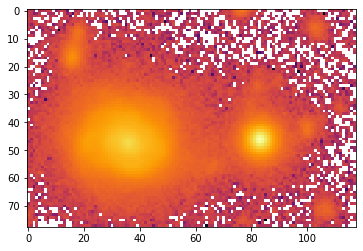

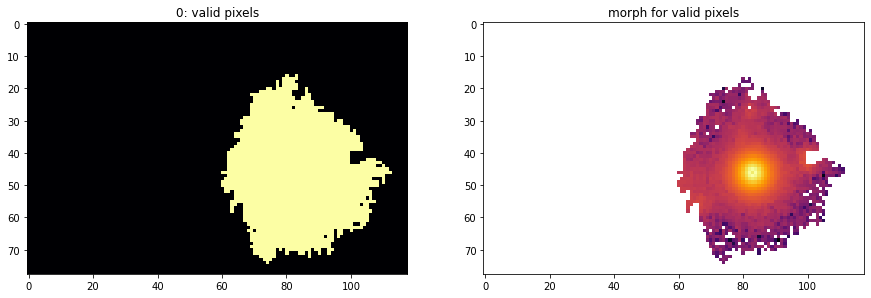

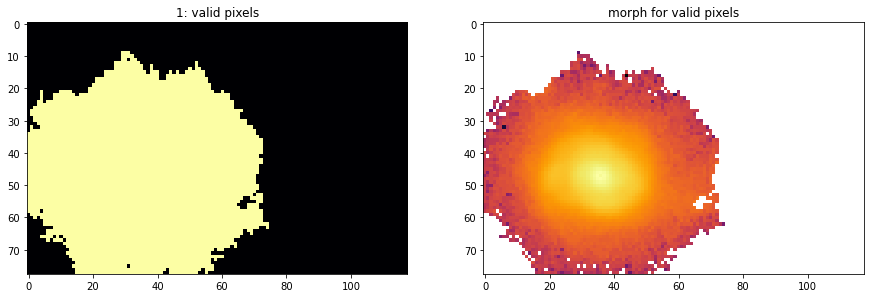

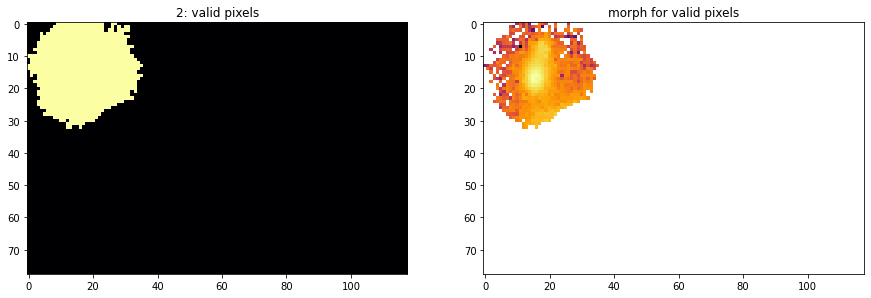

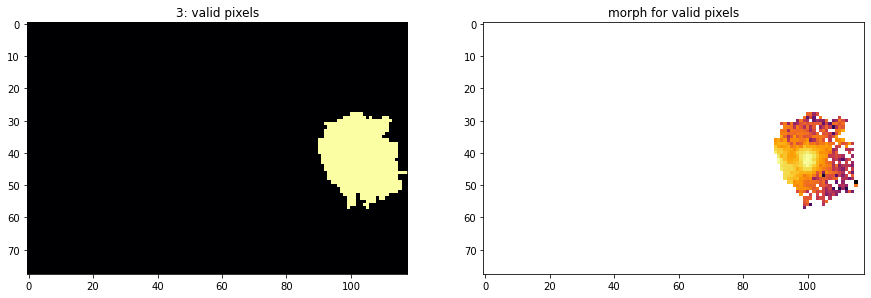

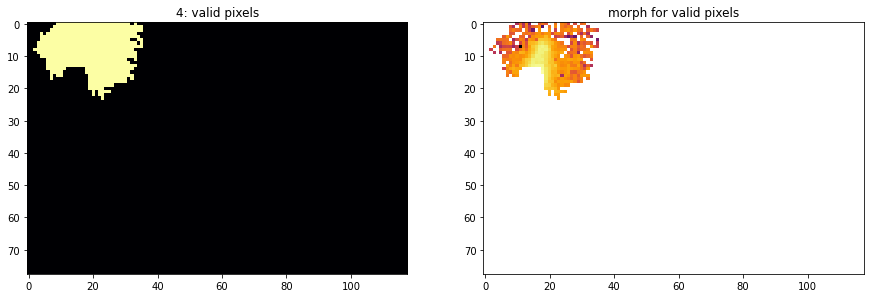

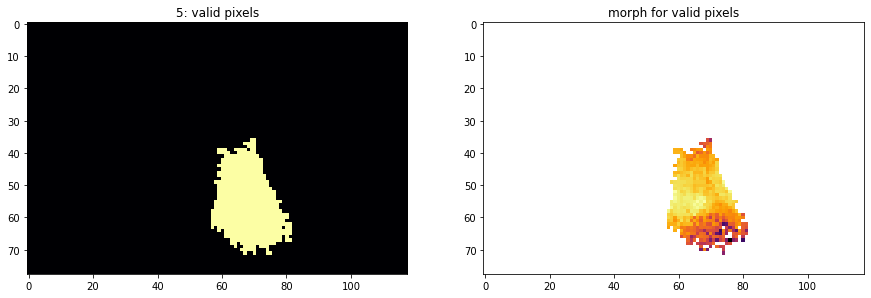

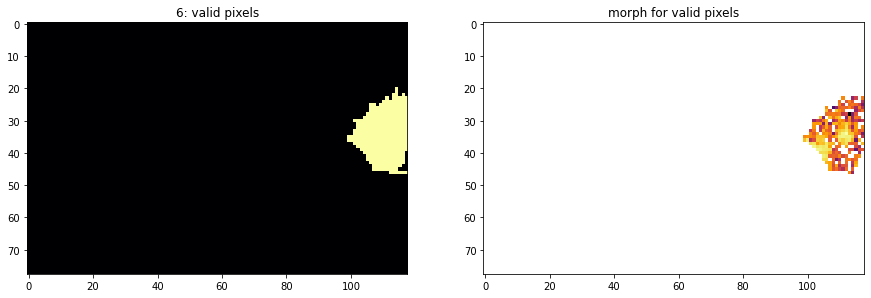

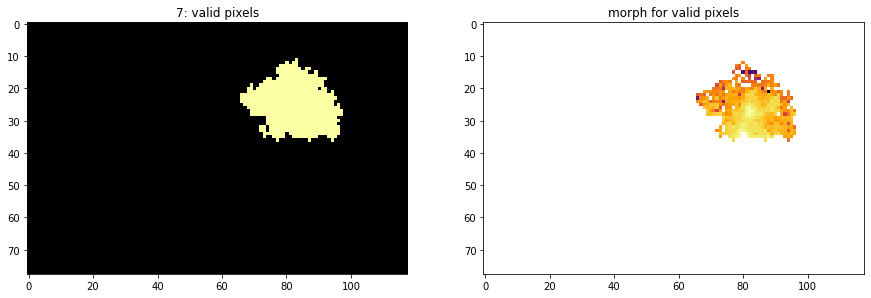

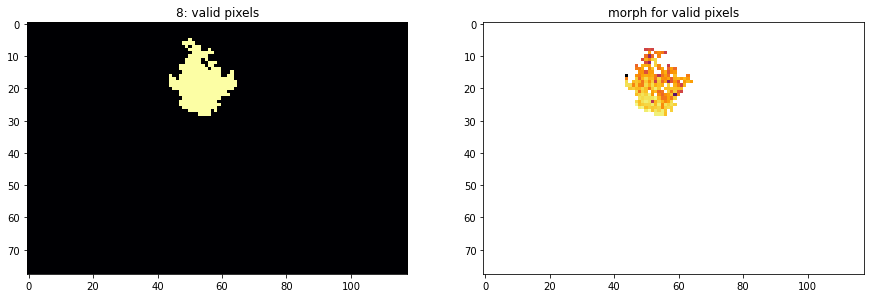

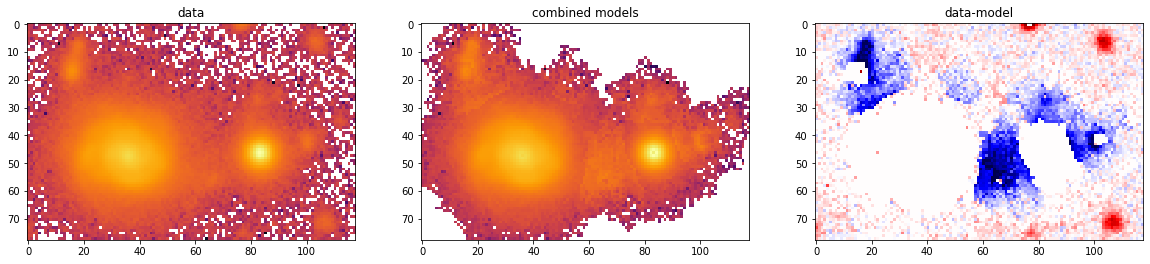

In [167]:
img = np.sum(images, axis=0)

plt.imshow(np.log10(img))
plt.show()

model = np.zeros(img.shape, dtype=float)

for k, center in enumerate(centers):
    valid, _model = monotonic_tree(img, center, radius=2, variance=0)
    fig = plt.figure(figsize=(15, 5))
    ax = [fig.add_subplot(1, 2, n+1) for n in range(2)]
    ax[0].imshow(valid)
    ax[0].set_title(f"{k}: valid pixels")
    ax[1].imshow(np.log10(_model))
    ax[1].set_title("morph for valid pixels")
    plt.show()
    
    model += _model

fig = plt.figure(figsize=(20, 7))
ax = [fig.add_subplot(1, 3, n+1) for n in range(3)]
ax[0].imshow(np.log10(img))
ax[0].set_title("data")
ax[1].imshow(np.log10(model))
ax[1].set_title("combined models")
residual = img - model
for n in range(4):
    residual[np.unravel_index(np.argmax(residual), residual.shape)] = 0
vmax = np.max(residual)
ax[2].imshow(residual, cmap="seismic", vmin=-vmax, vmax=vmax)
ax[2].set_title("data-model")
plt.show()